# Project 1: Exploratory Data Analysis

Things to uncover:
* Is case fatality rate higher in lower income neighborhoods in the states?

Useful links:
* COVID19 sociodemographic & socioeconmic factors research paper: https://www150.statcan.gc.ca/n1/daily-quotidien/220308/dq220308d-eng.htm#:~:text=The%20relationship%20between%20low%20income,in%20COVID%2D19%20mortality.
* Detailed income and employment statistics by state, county, and metropolitan area: https://apps.bea.gov/api/_pdf/bea_web_service_api_user_guide.pdf
* More information on factors of covid-19: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7221360/

## Analysis by State

In [1]:
# Importing dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy as sp
import pprint
import hvplot.pandas
import json
import matplotlib.patches as mpatches

# Importing api keys
from api_keys import BEA_api_key
from state_abbrevs import us_state_to_abbrev
from api_keys import census_api_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

### Requesting and Cleaning Average Income in USA Data

In [2]:
# Creating the average income query
AverageIncomeQuery_url_2021 = f'https://apps.bea.gov/api/data/?UserID={BEA_api_key}&method=GetData&datasetname=Regional&TableName=CAINC1&LineCode=3&Year=2021&GeoFips=COUNTY&ResultFormat=json'
AverageIncomeQueryResult_2021 = requests.get(AverageIncomeQuery_url_2021).json()

In [3]:
AverageIncomeQueryResult_2021

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'USERID',
     'ParameterValue': 'CED9A0BA-A0CE-4593-BEC8-8FD6623D9C05'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'REGIONAL'},
    {'ParameterName': 'TABLENAME', 'ParameterValue': 'CAINC1'},
    {'ParameterName': 'LINECODE', 'ParameterValue': '3'},
    {'ParameterName': 'YEAR', 'ParameterValue': '2021'},
    {'ParameterName': 'GEOFIPS', 'ParameterValue': 'COUNTY'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'}]},
  'Results': {'Statistic': 'Per capita personal income',
   'UnitOfMeasure': 'Dollars',
   'PublicTable': 'CAINC1 County and MSA personal income summary: personal income, population, per capita personal income',
   'UTCProductionTime': '2023-07-27T23:30:56.747',
   'NoteRef': '2',
   'Dimensions': [{'Name': 'Code', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoFips', 'DataType': 'string', 'IsValue': '0'},
    {'Name

In [4]:
AverageIncomeQueryResult_2021['BEAAPI']['Results']['Data'][0]

{'Code': 'CAINC1-3',
 'GeoFips': '01001',
 'GeoName': 'Autauga, AL',
 'TimePeriod': '2021',
 'CL_UNIT': 'Dollars',
 'UNIT_MULT': '0',
 'DataValue': '48,347'}

In [5]:
# Collect geofips, geoname, time period (only between 2020-2022), CL_UNIT, and DataValue
def generate_cleaned_median_income_dataframe(result):
    averageIncome = [] # Creating an empty array for storing the data

    for i in range(len(result['BEAAPI']['Results']['Data'])):
        averageIncome.append({
        'GeoName' : result['BEAAPI']['Results']['Data'][i]['GeoName'],
        'fips' : result['BEAAPI']['Results']['Data'][i]['GeoFips'],
        'TimePeriod' : result['BEAAPI']['Results']['Data'][i]['TimePeriod'],
        'CL_UNIT' : result['BEAAPI']['Results']['Data'][i]['CL_UNIT'],
        'DataValue' : result['BEAAPI']['Results']['Data'][i]['DataValue']
        })
    
    averageIncome_df = (pd.DataFrame(averageIncome)).rename(columns = {'GeoName' : 'County, State'})
    averageIncome_df['County, State'] = averageIncome_df['County, State'].map(lambda x: x.rstrip('(Independent City)').rstrip('*'))
    
    return averageIncome_df

In [6]:
# Creating a dataframe
averageIncome2021_df = generate_cleaned_median_income_dataframe(AverageIncomeQueryResult_2021)

In [7]:
# Saving the merged DataFrame to excel
averageIncome2021_df.to_csv('averageIncome_2021.csv')

In [8]:
# After reviewing the data, there are some counties with incorrect states
# ex. Brown, W should be Brown, WI. Hawai, Michigan, North Carolina, Sotuh Carolina, and Wiscon all had the same issues.
# This was manually adjusted using the following source: https://thefactfile.org/us-states-counties/
averageIncome_df = pd.read_csv('averageIncome_2021_adjusted.csv')
averageIncome_df.head()

,Unnamed: 0,"County, State",fips,TimePeriod,CL_UNIT,DataValue
0,0,"Autauga, AL",1001,2021,Dollars,"48,347"
1,1,"Baldwin, AL",1003,2021,Dollars,"54,659"
2,2,"Barbour, AL",1005,2021,Dollars,"40,428"
3,3,"Bibb, AL",1007,2021,Dollars,"36,892"
4,4,"Blount, AL",1009,2021,Dollars,"42,634"


In [9]:
cleaned_averageIncome_df = averageIncome_df.drop(['Unnamed: 0'], axis = 1)
cleaned_averageIncome_df.head()

,"County, State",fips,TimePeriod,CL_UNIT,DataValue
0,"Autauga, AL",1001,2021,Dollars,"48,347"
1,"Baldwin, AL",1003,2021,Dollars,"54,659"
2,"Barbour, AL",1005,2021,Dollars,"40,428"
3,"Bibb, AL",1007,2021,Dollars,"36,892"
4,"Blount, AL",1009,2021,Dollars,"42,634"


In [10]:
# Dropping rows with DataValue column value = (NA)
cleaned_averageIncome_df = cleaned_averageIncome_df[cleaned_averageIncome_df.DataValue != '(NA)']
cleaned_averageIncome_df.head()

,"County, State",fips,TimePeriod,CL_UNIT,DataValue
0,"Autauga, AL",1001,2021,Dollars,"48,347"
1,"Baldwin, AL",1003,2021,Dollars,"54,659"
2,"Barbour, AL",1005,2021,Dollars,"40,428"
3,"Bibb, AL",1007,2021,Dollars,"36,892"
4,"Blount, AL",1009,2021,Dollars,"42,634"


In [11]:
splitting_location_income = ((cleaned_averageIncome_df['County, State'].str.split(", ", expand = True)).rename(columns = {0 : 'County', 1: 'State'})).iloc[:,[0,1]]
splitting_location_income.head()

,County,State
0,Autauga,AL
1,Baldwin,AL
2,Barbour,AL
3,Bibb,AL
4,Blount,AL


In [12]:
income_by_county_df = splitting_location_income.join(cleaned_averageIncome_df).iloc[:,[0,1,6]]
income_by_county_df.head()

,County,State,DataValue
0,Autauga,AL,"48,347"
1,Baldwin,AL,"54,659"
2,Barbour,AL,"40,428"
3,Bibb,AL,"36,892"
4,Blount,AL,"42,634"


In [13]:
income_by_county_df.iloc[:,2] = (income_by_county_df.iloc[:,2].replace(',','', regex=True)).values.astype(int)
income_by_county_df.head()

,County,State,DataValue
0,Autauga,AL,48347
1,Baldwin,AL,54659
2,Barbour,AL,40428
3,Bibb,AL,36892
4,Blount,AL,42634


In [14]:
grouped_income_by_state_df = (income_by_county_df.groupby('State').mean(numeric_only=True)).reset_index()
cleaned_income_by_state_df = (grouped_income_by_state_df.drop([4,8,12,30,46], axis=0).reset_index()).iloc[:,[1,2]]
cleaned_income_by_state_df.head()

,State,DataValue
0,AK,68679.966667
1,AL,44408.119403
2,AR,43382.640000
3,AZ,47794.800000
4,CA,66942.034483


### Average Income by State Analysis

In [15]:
top_5_avg_income_states = cleaned_income_by_state_df.sort_values('DataValue', ascending=False).head(10)
top_5_avg_income_states

,State,DataValue
7,D,96477.000000
19,MA,79424.428571
39,R,74810.800000
31,NJ,74599.333333
6,CT,74295.875000
50,WY,69708.521739
28,ND,68992.981132
0,AK,68679.966667
30,NH,68631.400000
4,CA,66942.034483


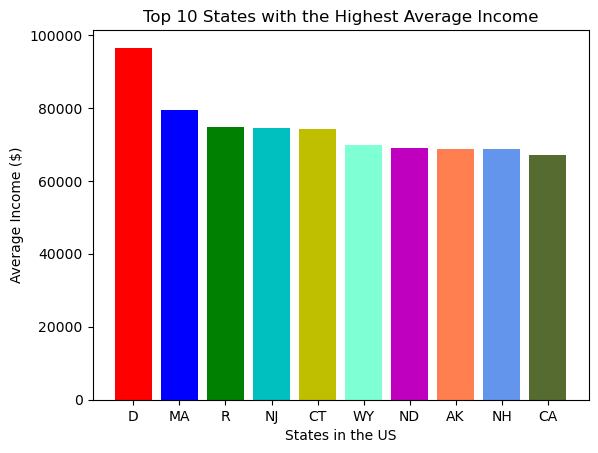

In [16]:
fig, ax = plt.subplots()

state = top_5_avg_income_states['State']
income = top_5_avg_income_states['DataValue']
bar_labels = top_5_avg_income_states['State']
bar_colors = ['r','b','g','c','y','aquamarine','m', 'coral', 'cornflowerblue', 'darkolivegreen']

ax.bar(state, income, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Income ($)')
ax.set_xlabel('States in the US')
ax.set_title('Top 10 States with the Highest Average Income')

plt.savefig('images\Top 10 States with the Highest Average Income.png')
plt.show()

In [17]:
bottom_5_avg_income_states = cleaned_income_by_state_df.sort_values('DataValue', ascending=True).head(10)
bottom_5_avg_income_states

,State,DataValue
25,MS,43064.146341
2,AR,43382.640000
1,AL,44408.119403
10,GA,44574.654088
17,KY,45306.850000
49,WV,45307.981818
24,MO,45659.478261
42,TN,46123.200000
40,SC,47170.021739
36,OK,47659.818182


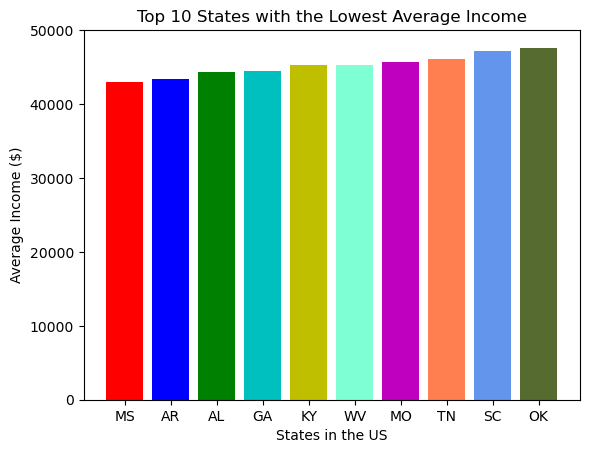

In [18]:
fig, ax = plt.subplots()

state = bottom_5_avg_income_states['State']
income = bottom_5_avg_income_states['DataValue']
bar_labels = bottom_5_avg_income_states['State']
bar_colors = ['r','b','g','c','y','aquamarine','m', 'coral', 'cornflowerblue', 'darkolivegreen']

ax.bar(state, income, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Income ($)')
ax.set_xlabel('States in the US')
ax.set_title('Top 10 States with the Lowest Average Income')

plt.savefig('images\Top 10 States with the Lowest Average Income.png')
plt.show()

### Importing and Cleaning COVID-19 Data

In [19]:
COVID19_metrics_df = pd.read_csv('us-counties-2021.csv')

In [20]:
print(len(COVID19_metrics_df))
COVID19_metrics_df.head()

1185373


,date,county,state,fips,cases,deaths
0,2021-01-01,Autauga,Alabama,1001.0,4239,50.0
1,2021-01-01,Baldwin,Alabama,1003.0,13823,169.0
2,2021-01-01,Barbour,Alabama,1005.0,1517,33.0
3,2021-01-01,Bibb,Alabama,1007.0,1854,46.0
4,2021-01-01,Blount,Alabama,1009.0,4693,63.0


In [21]:
COVID19_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185373 entries, 0 to 1185372
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   date    1185373 non-null  object 
 1   county  1185373 non-null  object 
 2   state   1185373 non-null  object 
 3   fips    1174570 non-null  float64
 4   cases   1185373 non-null  int64  
 5   deaths  1156903 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 54.3+ MB


In [22]:
COVID19_metrics_df.iloc[:,3] = COVID19_metrics_df.iloc[:,3].values.astype(int)

In [23]:
# Getting the last day of data from the dataset
cumulative_COVID19_metrics_df = COVID19_metrics_df[COVID19_metrics_df['date'] == '2021-12-31']
cumulative_COVID19_metrics_df.head()

,date,county,state,fips,cases,deaths
1182122,2021-12-31,Autauga,Alabama,1001,11018,160.0
1182123,2021-12-31,Baldwin,Alabama,1003,39911,593.0
1182124,2021-12-31,Barbour,Alabama,1005,3860,81.0
1182125,2021-12-31,Bibb,Alabama,1007,4533,95.0
1182126,2021-12-31,Blount,Alabama,1009,11256,198.0


In [24]:
abbreviated_COVID19_metrics_df = cumulative_COVID19_metrics_df.replace({'state': us_state_to_abbrev})
abbreviated_COVID19_metrics_df.head()

,date,county,state,fips,cases,deaths
1182122,2021-12-31,Autauga,AL,1001,11018,160.0
1182123,2021-12-31,Baldwin,AL,1003,39911,593.0
1182124,2021-12-31,Barbour,AL,1005,3860,81.0
1182125,2021-12-31,Bibb,AL,1007,4533,95.0
1182126,2021-12-31,Blount,AL,1009,11256,198.0


In [25]:
# Checking to see if there are any null values in the dataframe
bool_series_cases = abbreviated_COVID19_metrics_df['cases'].isnull().value_counts()
bool_series_deaths = abbreviated_COVID19_metrics_df['deaths'].isnull().value_counts()
print(f'{bool_series_cases} \n{bool_series_deaths}')

False    3251
Name: cases, dtype: int64 
False    3173
True       78
Name: deaths, dtype: int64


In [26]:
abbreviated_COVID19_metrics_df[abbreviated_COVID19_metrics_df['deaths'].isnull()]['state'].unique()

array(['PR'], dtype=object)

In [27]:
# Puerto Rico is the only state with null values so we will drop all of those values
cleaned_COVID19_metrics_df = abbreviated_COVID19_metrics_df.loc[(abbreviated_COVID19_metrics_df["state"] != 'PR')]
cleaned_COVID19_metrics_df.head()

,date,county,state,fips,cases,deaths
1182122,2021-12-31,Autauga,AL,1001,11018,160.0
1182123,2021-12-31,Baldwin,AL,1003,39911,593.0
1182124,2021-12-31,Barbour,AL,1005,3860,81.0
1182125,2021-12-31,Bibb,AL,1007,4533,95.0
1182126,2021-12-31,Blount,AL,1009,11256,198.0


In [28]:
CFR_metric_df = (cleaned_COVID19_metrics_df.dropna())[cleaned_COVID19_metrics_df.fips > 0]
CFR_metric_df.head()

,date,county,state,fips,cases,deaths
1182122,2021-12-31,Autauga,AL,1001,11018,160.0
1182123,2021-12-31,Baldwin,AL,1003,39911,593.0
1182124,2021-12-31,Barbour,AL,1005,3860,81.0
1182125,2021-12-31,Bibb,AL,1007,4533,95.0
1182126,2021-12-31,Blount,AL,1009,11256,198.0


### Case fatality rate by state (top 10 and bottom 10)

In [29]:
# Removing counties with deaths = 0
county_CFR_metric_df = CFR_metric_df[CFR_metric_df['deaths'] != 0.0]
grouped_CFR_state_df = CFR_metric_df.groupby('state').sum(numeric_only=True)
grouped_CFR_state_df.head()

,fips,cases,deaths
state,,,
AK,59724,155589,953.0
AL,71489,896614,16455.0
AR,380625,559422,9148.0
AZ,60208,1381487,24229.0
CA,351364,5515613,76709.0


In [30]:
grouped_CFR_state_df['Case Fatality Rate (%)'] = (grouped_CFR_state_df['deaths'] / grouped_CFR_state_df['cases'])*100
grouped_CFR_state_df.head()

,fips,cases,deaths,Case Fatality Rate (%)
state,,,,
AK,59724,155589,953.0,0.612511
AL,71489,896614,16455.0,1.835238
AR,380625,559422,9148.0,1.635259
AZ,60208,1381487,24229.0,1.753835
CA,351364,5515613,76709.0,1.390761


In [31]:
top_5_CFR_state_df = (grouped_CFR_state_df.sort_values('Case Fatality Rate (%)', ascending=False).head(10)).reset_index()
top_5_CFR_state_df

,state,fips,cases,deaths,Case Fatality Rate (%)
0,MS,2302724,543737,10450.0,1.921885
1,MA,350196,1058661,20261.0,1.913833
2,NJ,714441,1561259,29037.0,1.859845
3,AL,71489,896614,16455.0,1.835238
4,LA,1412096,828078,14986.0,1.809733
5,PA,2818489,2036424,36705.0,1.802424
6,CT,72064,508308,9158.0,1.801664
7,AZ,60208,1381487,24229.0,1.753835
8,MI,2164889,1704801,28968.0,1.699201
9,GA,2092677,1793593,30276.0,1.688008


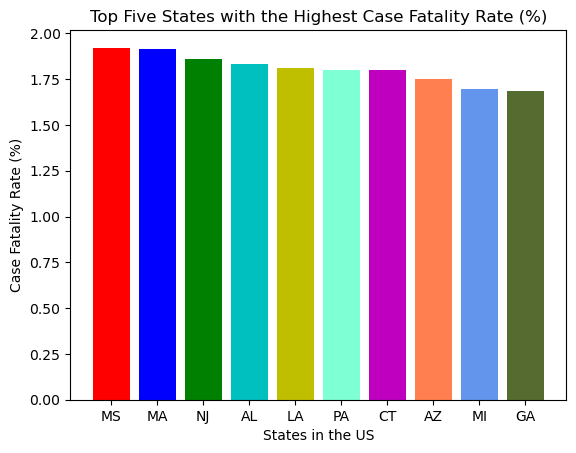

In [32]:
fig, ax = plt.subplots()

states = top_5_CFR_state_df['state']
cfr = top_5_CFR_state_df['Case Fatality Rate (%)']
bar_labels = top_5_CFR_state_df['state']
bar_colors = ['r','b','g','c','y','aquamarine','m', 'coral', 'cornflowerblue', 'darkolivegreen']

ax.bar(states, cfr, label=bar_labels, color=bar_colors)

ax.set_ylabel('Case Fatality Rate (%)')
ax.set_xlabel('States in the US')
ax.set_title('Top Five States with the Highest Case Fatality Rate (%)')
#ax.legend(title='States')

plt.savefig('images\Top Five States with the Highest Case Fatality Rate (%).png')
plt.show()

In [33]:
bottom_5_CFR_state_df = (grouped_CFR_state_df.sort_values('Case Fatality Rate (%)', ascending=True).head(10)).reset_index()
bottom_5_CFR_state_df

,state,fips,cases,deaths,Case Fatality Rate (%)
0,MP,138230,2963,11.0,0.371245
1,UT,1421841,635047,3733.0,0.587831
2,AK,59724,155589,953.0,0.612511
3,VT,700196,63734,471.0,0.739009
4,NE,2891649,336174,3068.0,0.912623
5,Virgin Islands,234060,9055,89.0,0.982882
6,HI,75025,109576,1079.0,0.984705
7,NH,330100,194894,1939.0,0.994900
8,WI,3965119,1120669,11173.0,0.996994
9,MN,2356569,1021588,10516.0,1.029378


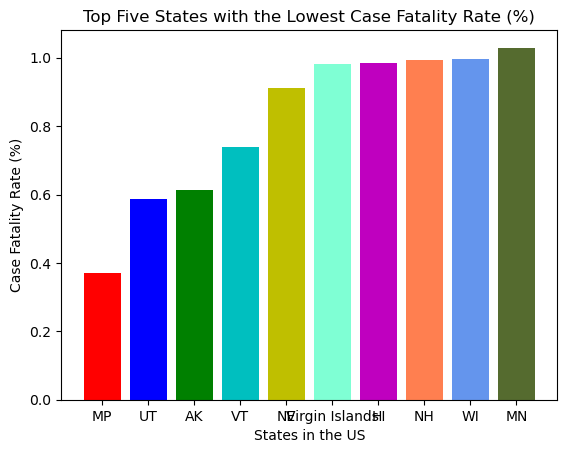

In [34]:
fig, ax = plt.subplots()

states = bottom_5_CFR_state_df['state']
cfr = bottom_5_CFR_state_df['Case Fatality Rate (%)']
bar_labels = bottom_5_CFR_state_df['state']
bar_colors = ['r','b','g','c','y','aquamarine','m', 'coral', 'cornflowerblue', 'darkolivegreen']

ax.bar(states, cfr, label=bar_labels, color=bar_colors)

ax.set_ylabel('Case Fatality Rate (%)')
ax.set_xlabel('States in the US')
ax.set_title('Top Five States with the Lowest Case Fatality Rate (%)')
#ax.legend(title='States')

plt.savefig('images\Top Five States with the Lowest Case Fatality Rate (%).png')
plt.show()

### Case Fatality Rate vs Average Income in Different States

In [35]:
cleaned_averageIncome_df.iloc[:,4] = (cleaned_averageIncome_df.iloc[:,4].replace(',','', regex=True)).values.astype(int)
cleaned_averageIncome_df.head()

,"County, State",fips,TimePeriod,CL_UNIT,DataValue
0,"Autauga, AL",1001,2021,Dollars,48347
1,"Baldwin, AL",1003,2021,Dollars,54659
2,"Barbour, AL",1005,2021,Dollars,40428
3,"Bibb, AL",1007,2021,Dollars,36892
4,"Blount, AL",1009,2021,Dollars,42634


In [36]:
income_CFR_county_state_df = cleaned_COVID19_metrics_df.merge(cleaned_averageIncome_df, how='left', on='fips').dropna()
income_CFR_county_state_df.head()

,date,county,state,fips,cases,deaths,"County, State",TimePeriod,CL_UNIT,DataValue
0,2021-12-31,Autauga,AL,1001,11018,160.0,"Autauga, AL",2021.0,Dollars,48347.0
1,2021-12-31,Baldwin,AL,1003,39911,593.0,"Baldwin, AL",2021.0,Dollars,54659.0
2,2021-12-31,Barbour,AL,1005,3860,81.0,"Barbour, AL",2021.0,Dollars,40428.0
3,2021-12-31,Bibb,AL,1007,4533,95.0,"Bibb, AL",2021.0,Dollars,36892.0
4,2021-12-31,Blount,AL,1009,11256,198.0,"Blount, AL",2021.0,Dollars,42634.0


In [37]:
grouped_income_CFR_state_df = (income_CFR_county_state_df.groupby('state').mean(numeric_only=True)).reset_index()
grouped_income_CFR_state_df.head()

,state,fips,cases,deaths,TimePeriod,DataValue
0,AK,2144.500000,6366.541667,39.041667,2021.0,66031.375000
1,AL,1067.000000,13382.298507,245.597015,2021.0,44408.119403
2,AR,5075.000000,7458.960000,121.973333,2021.0,43382.640000
3,AZ,4013.866667,92099.133333,1615.266667,2021.0,47794.800000
4,CA,6058.000000,95096.775862,1322.568966,2021.0,66942.034483


In [38]:
grouped_income_CFR_state_df['Case Fatality Rate (%)'] = (grouped_income_CFR_state_df['deaths']/grouped_income_CFR_state_df['cases'])*100
grouped_income_CFR_state_df.head()

,state,fips,cases,deaths,TimePeriod,DataValue,Case Fatality Rate (%)
0,AK,2144.500000,6366.541667,39.041667,2021.0,66031.375000,0.613232
1,AL,1067.000000,13382.298507,245.597015,2021.0,44408.119403,1.835238
2,AR,5075.000000,7458.960000,121.973333,2021.0,43382.640000,1.635259
3,AZ,4013.866667,92099.133333,1615.266667,2021.0,47794.800000,1.753835
4,CA,6058.000000,95096.775862,1322.568966,2021.0,66942.034483,1.390761


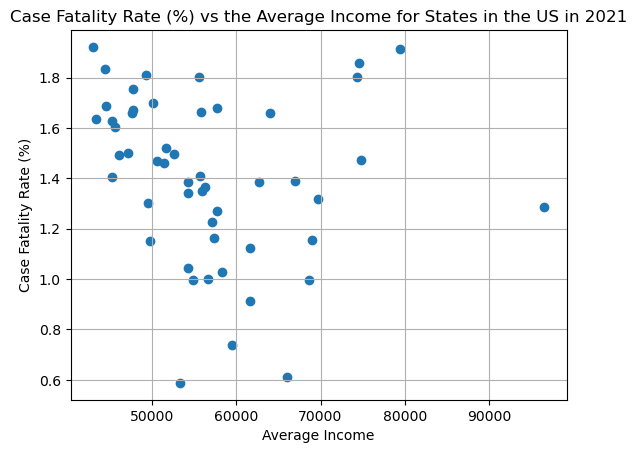

In [39]:
# Plotting CFR against avg income
x_vals = grouped_income_CFR_state_df['DataValue']
y_vals = grouped_income_CFR_state_df['Case Fatality Rate (%)']

plt.scatter(x_vals, y_vals)
plt.title('Case Fatality Rate (%) vs the Average Income for States in the US in 2021')
plt.xlabel('Average Income')
plt.ylabel('Case Fatality Rate (%)')
plt.grid()
plt.savefig('images\Case Fatality Rate (%) vs the Average Income for States in the US in 2021.png')
plt.show()

In [40]:
# Use pandas to give quartile calculations for average income
quartiles = grouped_income_CFR_state_df['DataValue'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of average income is: {lowerq}")
print(f"The upper quartile of average income is: {upperq}")
print(f"The interquartile range of average income is: {iqr}")
print(f"The the median of average income is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Income values below {lower_bound} could be outliers.")
print(f"Income values above {upper_bound} could be outliers.")

The lower quartile of average income is: 49434.63068181818
The upper quartile of average income is: 61665.09425403226
The interquartile range of average income is: 12230.463572214081
The the median of average income is: 55658.64179104478 
Income values below 31088.935323497055 could be outliers.
Income values above 80010.78961235337 could be outliers.


In [41]:
income_outliers_removed_df = grouped_income_CFR_state_df[(grouped_income_CFR_state_df['DataValue'] > lower_bound) & (grouped_income_CFR_state_df['DataValue'] < upper_bound)]

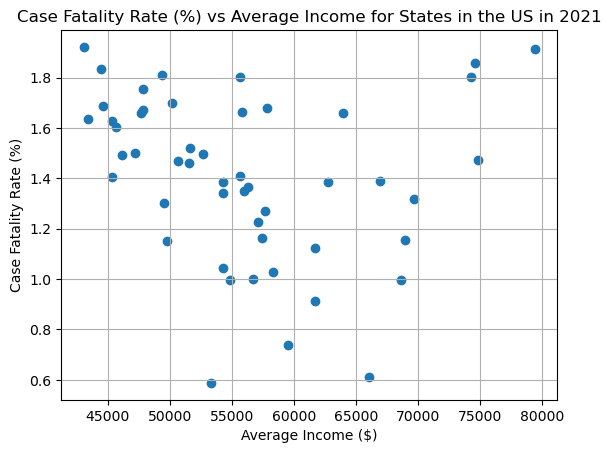

In [42]:
# Plotting CFR against avg income after removing the outliers from the income data
x_vals = income_outliers_removed_df['DataValue']
y_vals = income_outliers_removed_df['Case Fatality Rate (%)']

plt.scatter(x_vals, y_vals)
plt.title('Case Fatality Rate (%) vs Average Income for States in the US in 2021')
plt.xlabel('Average Income ($)')
plt.ylabel('Case Fatality Rate (%)')

plt.grid()
plt.savefig('images\Case Fatality Rate (%) vs Average Income ($) for States in the US in 2021.png')

plt.show()

In [43]:
county_CFR_income_correlation = sp.stats.pearsonr(x_vals,y_vals)
print(f"The correlation between both factors is {round(county_CFR_income_correlation[0],2)}")

The correlation between both factors is -0.18


### Split data and perform a T-test between the two income groups (split on the median income)

In [44]:
# Calculate median
state_median_income = income_outliers_removed_df['DataValue'].median()
print(f'The state median income is: {state_median_income}')

# Create two sample rows: Split data on median
lower_half = income_outliers_removed_df[income_outliers_removed_df['DataValue'] <= state_median_income]
upper_half = income_outliers_removed_df[income_outliers_removed_df['DataValue'] > state_median_income]

The state median income is: 55245.890339966834


In [45]:
upper_half

,state,fips,cases,deaths,TimePeriod,DataValue,Case Fatality Rate (%)
0,AK,2144.500000,6366.541667,39.041667,2021.0,66031.375000,0.613232
4,CA,6058.000000,95096.775862,1322.568966,2021.0,66942.034483,1.390761
5,CO,8062.234375,14582.140625,163.750000,2021.0,61661.156250,1.122949
6,CT,9008.000000,63538.500000,1144.750000,2021.0,74295.875000,1.801664
8,DE,10003.000000,59886.666667,762.000000,2021.0,57697.666667,1.272403
11,HI,15003.666667,32390.000000,324.333333,2021.0,56684.333333,1.001338
12,IA,19099.000000,5812.626263,79.373737,2021.0,56308.797980,1.365540
16,KS,20105.000000,4957.142857,66.952381,2021.0,55945.095238,1.350624
19,MA,25014.000000,75618.642857,1447.214286,2021.0,79424.428571,1.913833
20,MD,24044.958333,29184.041667,484.333333,2021.0,63989.958333,1.659583


In [46]:
# Perform T-test
t_test_state_median_income = sp.stats.ttest_ind(lower_half[['Case Fatality Rate (%)']], upper_half[['Case Fatality Rate (%)']])

print(f'The pvalue of the Average Income is: {t_test_state_median_income[1]}')

The pvalue of the Average Income is: [0.10689559]


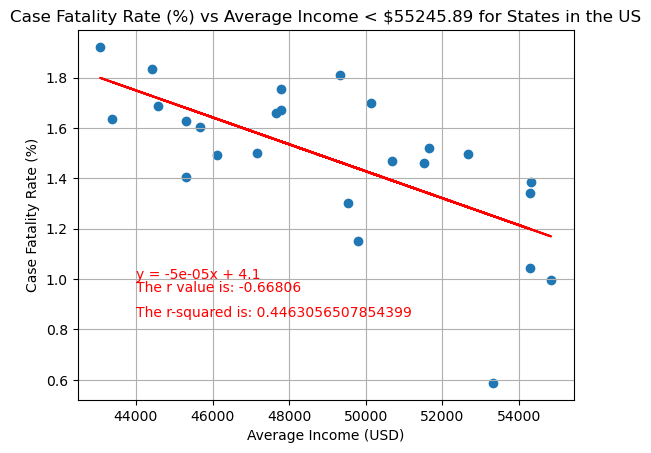

In [47]:
# Create a bar chart
x_vals = lower_half['DataValue']
y_vals = lower_half['Case Fatality Rate (%)']

# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = sp.stats.linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))

plt.scatter(x_vals, y_vals)
plt.plot(x_vals,regress_values,"r-")

plt.title(f'Case Fatality Rate (%) vs Average Income < ${round(state_median_income, 2)} for States in the US')
plt.xlabel('Average Income (USD)')
plt.ylabel('Case Fatality Rate (%)')

plt.annotate(line_eq,(44000,1),fontsize=10,color="red")
plt.annotate(f"The r value is: {round(rvalue,5)}",(44000,0.95),fontsize=10,color="red")
plt.annotate(f"The r-squared is: {rvalue**2}",(44000,0.85),fontsize=10,color="red")

plt.grid()
plt.savefig('images\CFR and avg income below avg median income for states.png')

plt.show()

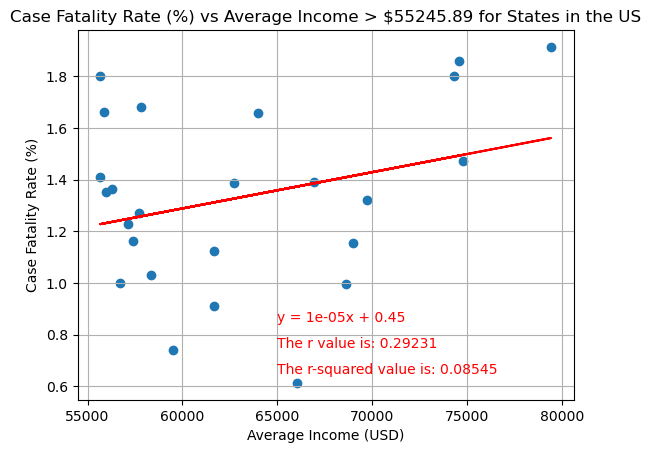

In [48]:
# Create a scatter plot
x_vals = upper_half['DataValue']
y_vals = upper_half['Case Fatality Rate (%)']

# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = sp.stats.linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))

plt.scatter(x_vals, y_vals)
plt.plot(x_vals,regress_values,"r-")

plt.title(f'Case Fatality Rate (%) vs Average Income > ${round(state_median_income, 2)} for States in the US')
plt.xlabel('Average Income (USD)')
plt.ylabel('Case Fatality Rate (%)')

plt.annotate(line_eq,(65000,0.85),fontsize=10,color="red")
plt.annotate(f"The r value is: {round(rvalue,5)}",(65000,0.75),fontsize=10,color="red")
plt.annotate(f"The r-squared value is: {round(rvalue**2,5)}",(65000,0.65),fontsize=10,color="red")

plt.grid()
plt.savefig('images\CFR and avg income above avg median income state.png')

plt.show()

### Poverty vs CFR

In [49]:
pov_url = f'https://api.census.gov/data/timeseries/poverty/saipe/variables?get=NAME,SAEPOVALL_PT,SAEPOVRTALL_PT,SAEMHI_PT&for=county:*&time=2021&key={census_api_key}'

In [50]:
pv_response = requests.get(pov_url).json()

In [51]:
pv_response

[['NAME',
  'SAEPOVALL_PT',
  'SAEPOVRTALL_PT',
  'SAEMHI_PT',
  'time',
  'state',
  'county'],
 ['Autauga County', '6296', '10.7', '66444', '2021', '01', '001'],
 ['Baldwin County', '25526', '10.8', '65658', '2021', '01', '003'],
 ['Barbour County', '5089', '23.0', '38649', '2021', '01', '005'],
 ['Bibb County', '4204', '20.6', '48454', '2021', '01', '007'],
 ['Blount County', '6992', '12.0', '56894', '2021', '01', '009'],
 ['Bullock County', '2764', '32.1', '32027', '2021', '01', '011'],
 ['Butler County', '4226', '22.7', '39442', '2021', '01', '013'],
 ['Calhoun County', '21630', '19.2', '48166', '2021', '01', '015'],
 ['Chambers County', '6699', '19.7', '45447', '2021', '01', '017'],
 ['Cherokee County', '4513', '18.2', '46365', '2021', '01', '019'],
 ['Chilton County', '6973', '15.5', '55142', '2021', '01', '021'],
 ['Choctaw County', '2893', '23.3', '40601', '2021', '01', '023'],
 ['Clarke County', '4366', '19.4', '45447', '2021', '01', '025'],
 ['Clay County', '2560', '18.4', '

In [52]:
pov_df = ((pd.DataFrame(pv_response, columns = pv_response[0])).iloc[1:,:]).rename(columns = {
    'SAEPOVALL_PT' : 'Poverty Count',
    'SAEPOVRTALL_PT' : 'Poverty Rate',
    'SAEMHI_PT' : 'Median Household Income'
})
pov_df.head()

,NAME,Poverty Count,Poverty Rate,Median Household Income,time,state,county
1,Autauga County,6296,10.7,66444,2021,01,001
2,Baldwin County,25526,10.8,65658,2021,01,003
3,Barbour County,5089,23.0,38649,2021,01,005
4,Bibb County,4204,20.6,48454,2021,01,007
5,Blount County,6992,12.0,56894,2021,01,009


In [53]:
pov_df['state'] = pov_df['state'].replace('01', '1')
pov_df['fips'] = (pov_df['state'] + pov_df['county']).astype(int)
pov_df = pov_df.iloc[:,[1,2,3,7]]
pov_df.head()

,Poverty Count,Poverty Rate,Median Household Income,fips
1,6296,10.7,66444,1001
2,25526,10.8,65658,1003
3,5089,23.0,38649,1005
4,4204,20.6,48454,1007
5,6992,12.0,56894,1009


In [54]:
income_CFR_state_df = income_CFR_county_state_df
income_CFR_state_df['CFR'] = (income_CFR_state_df['deaths']/income_CFR_state_df['cases'])*100
income_CFR_state_df

,date,county,state,fips,cases,deaths,"County, State",TimePeriod,CL_UNIT,DataValue,CFR
0,2021-12-31,Autauga,AL,1001,11018,160.0,"Autauga, AL",2021.0,Dollars,48347.0,1.452169
1,2021-12-31,Baldwin,AL,1003,39911,593.0,"Baldwin, AL",2021.0,Dollars,54659.0,1.485806
2,2021-12-31,Barbour,AL,1005,3860,81.0,"Barbour, AL",2021.0,Dollars,40428.0,2.098446
3,2021-12-31,Bibb,AL,1007,4533,95.0,"Bibb, AL",2021.0,Dollars,36892.0,2.095742
4,2021-12-31,Blount,AL,1009,11256,198.0,"Blount, AL",2021.0,Dollars,42634.0,1.759062
...,...,...,...,...,...,...,...,...,...,...,...
3167,2021-12-31,Sweetwater,WY,56037,8320,107.0,"Sweetwater, WY",2021.0,Dollars,56934.0,1.286058
3168,2021-12-31,Teton,WY,56039,5950,14.0,"Teton, WY",2021.0,Dollars,318297.0,0.235294
3169,2021-12-31,Uinta,WY,56041,4154,31.0,"Uinta, WY",2021.0,Dollars,44157.0,0.746269
3170,2021-12-31,Washakie,WY,56043,1879,37.0,"Washakie, WY",2021.0,Dollars,60235.0,1.969133


In [55]:
pov_income_df = income_CFR_state_df.merge(pov_df, how='left', on='fips').dropna().iloc[:,[1,2,10,12]]
pov_income_df

,county,state,CFR,Poverty Rate
0,Autauga,AL,1.452169,10.7
1,Baldwin,AL,1.485806,10.8
2,Barbour,AL,2.098446,23.0
3,Bibb,AL,2.095742,20.6
4,Blount,AL,1.759062,12.0
...,...,...,...,...
3074,Sweetwater,WY,1.286058,9.2
3075,Teton,WY,0.235294,5.9
3076,Uinta,WY,0.746269,9.4
3077,Washakie,WY,1.969133,10.2


In [56]:
pov_income_df['Poverty Rate'] = pov_income_df['Poverty Rate'].astype(float)
state_pov_income_df = pov_income_df.groupby('state').mean().reset_index()
state_pov_income_df.head()

,state,CFR,Poverty Rate
0,AK,0.505504,13.725000
1,AL,2.213118,19.455224
2,AR,1.984395,18.750667
3,AZ,2.240928,17.273333
4,CA,1.160450,13.631034


In [57]:
# Poverty VS Income scatter plot
y_vals = state_pov_income_df['CFR']
x_vals = state_pov_income_df['Poverty Rate']

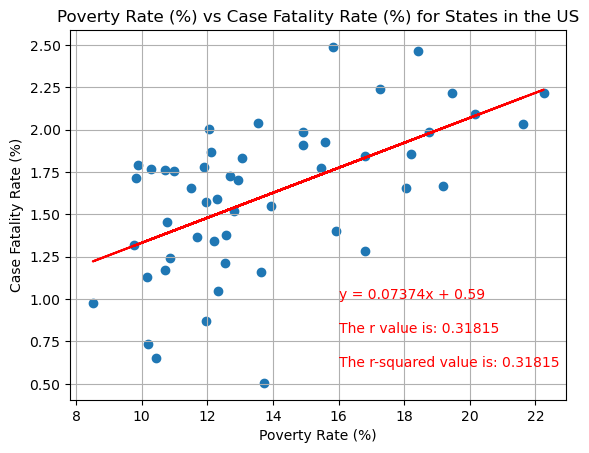

In [58]:
# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = sp.stats.linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))

plt.scatter(x_vals, y_vals)
plt.plot(x_vals,regress_values,"r-")

plt.title(f'Poverty Rate (%) vs Case Fatality Rate (%) for States in the US')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Case Fatality Rate (%)')

plt.annotate(line_eq,(16,1),fontsize=10,color="red")
plt.annotate(f"The r value is: {round(rvalue**2,5)}",(16,0.8),fontsize=10,color="red")
plt.annotate(f"The r-squared value is: {round(rvalue**2,5)}",(16,0.6),fontsize=10,color="red")

plt.grid()
plt.savefig('images\Income vs Poverty for States in the US with outliers.png')

plt.show()

In [59]:
# Use pandas to give quartile calculations for average income
quartiles = state_pov_income_df['Poverty Rate'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of average income is: {lowerq}")
print(f"The upper quartile of average income is: {upperq}")
print(f"The interquartile range of average income is: {iqr}")
print(f"The the median of average income is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Income values below {lower_bound} could be outliers.")
print(f"Income values above {upper_bound} could be outliers.")

The lower quartile of average income is: 11.253442028985507
The upper quartile of average income is: 15.884003937007874
The interquartile range of average income is: 4.630561908022367
The the median of average income is: 12.698780487804877 
Income values below 4.307599166951957 could be outliers.
Income values above 22.829846799041423 could be outliers.


In [60]:
state_pov_income_outliers_removed_df = state_pov_income_df[(state_pov_income_df['Poverty Rate'] > lower_bound) & (state_pov_income_df['Poverty Rate'] < upper_bound)]

In [61]:
# Poverty VS Income scatter plot
y_vals = state_pov_income_outliers_removed_df['CFR']
x_vals = state_pov_income_outliers_removed_df['Poverty Rate']

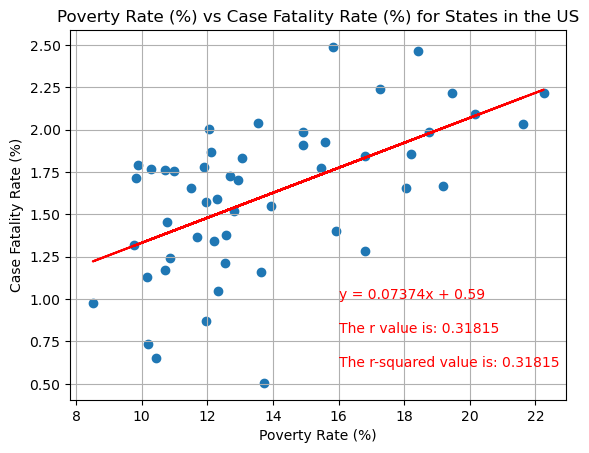

In [62]:
# Perform linear regression
(slope, intercept, rvalue, pvalue, stderr) = sp.stats.linregress(x_vals, y_vals)
regress_values = x_vals * slope + intercept
line_eq = "y = " + str(round(slope,5)) + "x + " + str(round(intercept,2))

plt.scatter(x_vals, y_vals)
plt.plot(x_vals,regress_values,"r-")

plt.title(f'Poverty Rate (%) vs Case Fatality Rate (%) for States in the US')
plt.xlabel('Poverty Rate (%)')
plt.ylabel('Case Fatality Rate (%)')

plt.annotate(line_eq,(16,1),fontsize=10,color="red")
plt.annotate(f"The r value is: {round(rvalue**2,5)}",(16,0.8),fontsize=10,color="red")
plt.annotate(f"The r-squared value is: {round(rvalue**2,5)}",(16,0.6),fontsize=10,color="red")

plt.grid()
plt.savefig('images\Income vs Poverty for States in the US.png')

plt.show()